In [16]:
#Sentiment analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import string

print("="*50)
print("Sentiment Analysis- IMBD Movie Reviews")
print("="*50)

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"Gpu enabled {gpu_devices[0].name}")
else:
    print("No Gpu")
print("="*50)

Sentiment Analysis- IMBD Movie Reviews
Gpu enabled /physical_device:GPU:0


In [2]:
#loading the IMBD dataset

print("="*50)
print("Loading the IMBD Reviews Dataset...")
print("="*50)

(x_train,y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words = 10000)

print(f"\nTraining reviews: {len(x_train):,}")
print(f"Test reviews: {len(x_test):,}")
print(f"Total reviews: {len(x_train)+len(x_test):,}")

unique,counts = np.unique(y_train, return_counts = True)
print(f"\nLabel Distribution Training: ")
print(f"Negative(0): {counts[0]:,} reviews")
print(f"Positive(1): {counts[1]:,} reviews")
print(f"Example review length: {len(x_train[0])} words")

max_len = 200

Loading the IMBD Reviews Dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training reviews: 25,000
Test reviews: 25,000
Total reviews: 50,000

Label Distribution Training: 
Negative(0): 12,500 reviews
Positive(1): 12,500 reviews
Example review length: 218 words


In [3]:
#decode and visualize sample reviews

print("="*50)
print("Lets Look at the reviews")
print("="*50)


word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = {value:key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ''.join([reverse_word_index.get(i-3, '?') for i in encoded_review])

print("="*50)
print("Sample Reviews")
print("="*50)

for i in range(3):
    print(f"Review #{i+1}")
    print(f"Sentiment: {'Positive' if y_train[i] == 1 else 'Negative'}")
    decoded = decode_review(x_train[i])
    print(decoded[:500] + "..." if len(decoded)>500 else decoded)

print("\n These are real Reviews")

Lets Look at the reviews
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Sample Reviews
Review #1
Sentiment: Positive
?thisfilmwasjustbrilliantcastinglocationscenerystorydirectioneveryone'sreallysuitedtheparttheyplayedandyoucouldjustimaginebeingthererobert?isanamazingactorandnowthesamebeingdirector?fathercamefromthesamescottishislandasmyselfsoilovedthefacttherewasarealconnectionwiththisfilmthewittyremarksthroughoutthefilmweregreatitwasjustbrilliantsomuchthatiboughtthefilmassoonasitwasreleasedfor?andwouldrecommendittoeveryonetowatchandtheflyfishingwasamazingreallycriedattheenditwassosadandyouknowwhattheysayifyou...
Review #2
Sentiment: Negative
?bighairbigboobsbadmusicandagiantsafetypinthesearethewordstobestdescribethisterriblemovieilovecheesyhorrormoviesandi'veseenhundredsbutthishadgottobeonoftheworstevermadetheplotispaperthinandridiculoustheactingisanabominationthescriptiscompletelylaughablethebestistheendshowdownwiththecopandhowheworkedoutwhothekillerisit'sjustsodamnterriblywrittent

In [5]:
#Preprocessing

print("="*50)
print("Preprocessing")
print("="*50)

x_train_padded = pad_sequences(x_train, maxlen=max_len, padding = 'post',truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding = 'post',  truncating='post')

print(f"Max sequence length: {max_len} words")
print(f"Vocabulary size: 10,000 unique words")
print(f"\nTraining data shape: {x_train_padded.shape}")
print(f" -> {x_train_padded.shape[0]:,} reviews")
print(f" -> {x_train_padded.shape[1]:,} words each (padded)")
print(f"\nTraining data shape: {x_train_padded.shape}")
print("="*50)

print("\nPadding Explained:")
print("  Short review (50 words) → Add 150 zeros at end")
print("  Long review (500 words) → Keep first 200 words")
print("  Result: All reviews same length → LSTM can process!")

Preprocessing
Max sequence length: 200 words
Vocabulary size: 10,000 unique words

Training data shape: (25000, 200)
 -> 25,000 reviews
 -> 200 words each (padded)

Training data shape: (25000, 200)

Padding Explained:
  Short review (50 words) → Add 150 zeros at end
  Long review (500 words) → Keep first 200 words
  Result: All reviews same length → LSTM can process!


In [6]:
#Build The LSTM model

print("="*50)
print("Building LSTM Neural Network")
print("="*50)

max_len = 200
vocab_size = 10000
embedding_dim = 128

model = keras.Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid')
])

print("="*50)
print("LSTM Architecture")
print("="*50)
model.build(input_shape=(None, max_len))
model.summary()

print()
print("="*50)
print("Architecture breakdown")
print("="*50)
print("1. EMBEDDING LAYER:")
print("   → Converts word indices to 128-dim vectors")
print("   → Words with similar meaning get similar vectors")
print("   → 'good', 'great', 'amazing' → close in vector space")
print("\n2. BIDIRECTIONAL LSTM (64 units):")
print("   → Reads text LEFT to RIGHT")
print("   → Also reads RIGHT to LEFT")
print("   → Captures context from both directions!")
print("\n3. BIDIRECTIONAL LSTM (32 units):")
print("   → Learns higher-level patterns")
print("   → Understands sentiment cues")
print("\n4. DENSE LAYERS:")
print("   → Dense(64): Combines features")
print("   → Dropout(0.5): Prevents overfitting")
print("   → Dense(1): Final sentiment score (0-1)")
print("="*50)


Building LSTM Neural Network
LSTM Architecture


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,257 (5.43 MB)

 Trainable params: 1,424,257 (5.43 MB)

 Non-trainable params: 0 (0.00 B)


Architecture breakdown
1. EMBEDDING LAYER:
   → Converts word indices to 128-dim vectors
   → Words with similar meaning get similar vectors
   → 'good', 'great', 'amazing' → close in vector space

2. BIDIRECTIONAL LSTM (64 units):
   → Reads text LEFT to RIGHT
   → Also reads RIGHT to LEFT
   → Captures context from both directions!

3. BIDIRECTIONAL LSTM (32 units):
   → Learns higher-level patterns
   → Understands sentiment cues

4. DENSE LAYERS:
   → Dense(64): Combines features
   → Dropout(0.5): Prevents overfitting
   → Dense(1): Final sentiment score (0-1)


In [7]:
#compile model

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print("="*50)
print("Model compiled")
print("="*50)

print("Optimizer: Adam")
print("Loss: Binary Crossentropy (positive vs negative)")
print("Metric: Accuracy\n")
print("="*50)


Model compiled
Optimizer: Adam
Loss: Binary Crossentropy (positive vs negative)
Metric: Accuracy



In [8]:
#Training

print("="*50)
print("LSTM Training")
print("="*50)
print()

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split( x_train_padded, y_train, test_size=0.2, random_state=42)

early_stops = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    restore_best_weights = True,
    verbose = 1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/sentiment_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose =1
)

epochs = 5
batch_size = 128

history = model.fit(
    x_train_split,
    y_train_split,
    epochs = epochs,
    batch_size =batch_size,
    validation_data = (x_val_split, y_val_split),
    callbacks = [early_stops, checkpoint],
    verbose = 1
)


LSTM Training

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6178 - loss: 0.6317
Epoch 1: val_accuracy improved from -inf to 0.65380, saving model to /content/sentiment_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.6183 - loss: 0.6314 - val_accuracy: 0.6538 - val_loss: 0.8069
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7157 - loss: 0.6002
Epoch 2: val_accuracy improved from 0.65380 to 0.77020, saving model to /content/sentiment_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7157 - loss: 0.5999 - val_accuracy: 0.7702 - val_loss: 0.4980
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8093 - loss: 0.4423
Epoch 3: val_accuracy improved from 0.77020 to 0.80460, saving model to /content/sentiment_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8094 - loss: 0.4421 - val_accuracy: 0.8046 - val_loss: 0.4471
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8695 - loss: 0.3370
Epoch 4: val_accuracy improved from 0.80460 to 0.83480, saving model to /content/sentiment_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8695 - loss: 0.3370 - val_accuracy: 0.8348 - val_loss: 0.3943
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9041 - loss: 0.2624
Epoch 5: val_accuracy improved from 0.83480 to 0.84560, saving model to /content/sentiment_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9041 - loss: 0.2624 - val_accuracy: 0.8456 - val_loss: 0.3869
Restoring model weights from the end of the best epoch: 5.


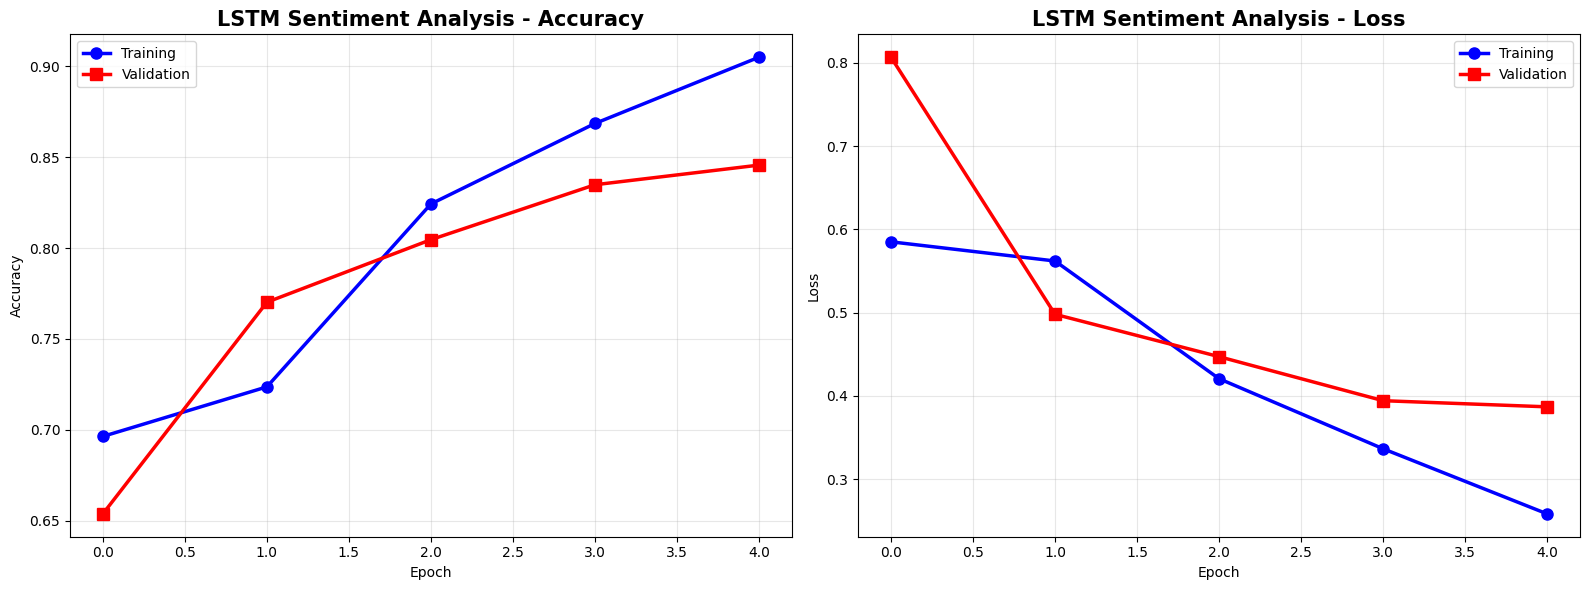

Final results
Training Accuracy: 90.50%
Validation Accuracy: 84.56%


In [9]:
#training visualization

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_completed = len(acc)
epochs_range = range(epochs_completed)

fig, axes = plt.subplots(1, 2, figsize = (16,6))

#accuracy
axes[0].plot(epochs_range, acc, 'bo-', label='Training', linewidth=2.5, markersize=8)
axes[0].plot(epochs_range, val_acc, 'rs-', label='Validation', linewidth=2.5, markersize=8)
axes[0].set_title('LSTM Sentiment Analysis - Accuracy', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#loss
axes[1].plot(epochs_range, loss, 'bo-', label='Training', linewidth=2.5, markersize=8)
axes[1].plot(epochs_range, val_loss, 'rs-', label='Validation', linewidth=2.5, markersize=8)
axes[1].set_title('LSTM Sentiment Analysis - Loss', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_train_acc = acc[-1]*100
final_val_acc = val_acc[-1]*100

print("="*50)
print("Final results")
print("="*50)
print(f"Training Accuracy: {final_train_acc:.2f}%")
print(f"Validation Accuracy: {final_val_acc:.2f}%")
print("="*50)


In [10]:
#Evaluation on Test set

print("="*50)
print("Testing on 25k unseen reviews...")
print("="*50)

test_loss, test_accuracy = model.evaluate(x_test_padded, y_test, verbose =0)

print("="*50)
print("Results")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print("="*50)


correct = int(test_accuracy*25000)
print(f"\nGot {correct:,} out of 25k reviews")
print(f"Missed {25000-correct:,} reviews")


Testing on 25k unseen reviews...
Results
Test Loss: 0.4229
Test Accuracy: 82.71%

Got 20,677 out of 25k reviews
Missed 4,323 reviews


In [13]:
#test on custom reviews

print("="*50)
print("Testing on custom reviews")
print("="*50)

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

def predict_sentiment(review_text):
    words = clean_text(review_text).split()
    #preprocess
    encoded = [
        word_index[word]+3 if word in word_index else 2
        for word in words]

    padded = pad_sequences([encoded],maxlen = max_len, padding = 'post', truncating='post')

    #predict
    prediction = model.predict(padded, verbose=0)[0][0]
    sentiment = 'Positive' if prediction > 0.5 else 'Negative'
    confidence = prediction*100 if prediction >0.5 else (1-prediction)*100

    return sentiment, confidence

test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it. Best film I've seen in years!",
    "Terrible waste of time. The plot made no sense and the acting was awful.",
    "It was okay, nothing special. Some good parts, some bad parts.",
    "Absolutely brilliant! A masterpiece of cinema. Highly recommended!",
    "Boring and predictable. I fell asleep halfway through.",
    "Pretty good movie. Worth watching if you like this genre."
]


for i, review in enumerate(test_reviews, 1):

    print()
    print(f'"{review}"')

    sentiment, confidence = predict_sentiment(review)

    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.1f}%")

Testing on custom reviews

"This movie was absolutely amazing! I loved every minute of it. Best film I've seen in years!"
Prediction: Positive
Confidence: 96.7%

"Terrible waste of time. The plot made no sense and the acting was awful."
Prediction: Negative
Confidence: 96.3%

"It was okay, nothing special. Some good parts, some bad parts."
Prediction: Negative
Confidence: 73.1%

"Absolutely brilliant! A masterpiece of cinema. Highly recommended!"
Prediction: Positive
Confidence: 93.8%

"Boring and predictable. I fell asleep halfway through."
Prediction: Negative
Confidence: 91.7%

"Pretty good movie. Worth watching if you like this genre."
Prediction: Positive
Confidence: 55.6%


Confusion Matrix
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


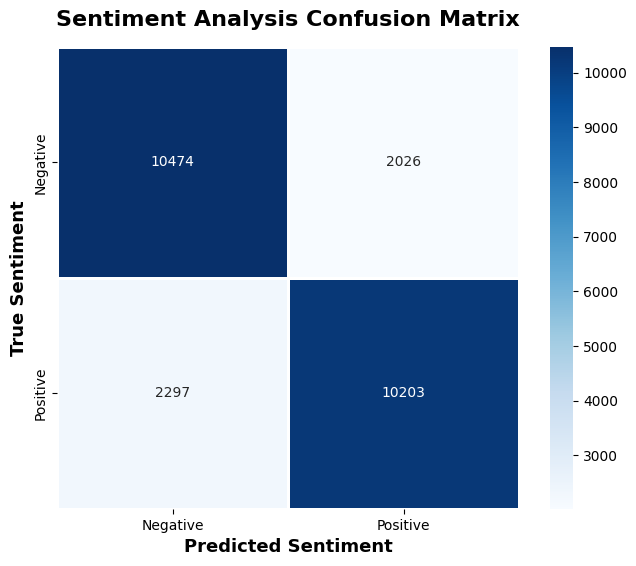

How to read
  Top-left: Negative correctly identified
  Bottom-right: Positive correctly identified
  Top-right: Negative wrongly predicted as positive
  Bottom-left: Positive wrongly predicted as negative

Classification Report
              precision    recall  f1-score   support

    Negative       0.82      0.84      0.83     12500
    Positive       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [17]:
#Confusion Martrix

print("="*50)
print("Confusion Matrix")
print("="*50)

test_predictions = model.predict(x_test_padded, verbose=1)
test_pred_labels = (test_predictions > 0.5).astype(int).flatten()


cm = confusion_matrix(y_test, test_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar=True, square=True, linewidths=2)
plt.title('Sentiment Analysis Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Sentiment', fontsize=13, fontweight='bold')
plt.ylabel('True Sentiment', fontsize=13, fontweight='bold')
plt.show()

print("How to read")
print("  Top-left: Negative correctly identified")
print("  Bottom-right: Positive correctly identified")
print("  Top-right: Negative wrongly predicted as positive")
print("  Bottom-left: Positive wrongly predicted as negative")

print()
print("="*50)
print("Classification Report")
print("="*50)

print(classification_report(y_test, test_pred_labels, target_names = ['Negative', 'Positive']))

In [18]:
#Final Summary

print("_"*50)
print("Completed sentiment analysis")
print("_"*50)

print((f"Achieved {test_accuracy*100:.2f}% test accuracy!\n"))
print("\nWHY LSTMs FOR TEXT:")
print("  • Text is sequential (order matters!)")
print("  • LSTMs remember context over long sequences")
print("  • 'not good' vs 'very good' - context changes meaning")
print("  • Bidirectional = understands full context!")

print("\nREAL-WORLD APPLICATIONS:")
print("  • Social media monitoring (Twitter sentiment)")
print("  • Product review analysis (Amazon, Yelp)")
print("  • Customer feedback categorization")
print("  • Brand reputation monitoring")
print("  • Stock market sentiment (news analysis)")


__________________________________________________
Completed sentiment analysis
__________________________________________________
Achieved 82.71% test accuracy!


WHY LSTMs FOR TEXT:
  • Text is sequential (order matters!)
  • LSTMs remember context over long sequences
  • 'not good' vs 'very good' - context changes meaning
  • Bidirectional = understands full context!

REAL-WORLD APPLICATIONS:
  • Social media monitoring (Twitter sentiment)
  • Product review analysis (Amazon, Yelp)
  • Customer feedback categorization
  • Brand reputation monitoring
  • Stock market sentiment (news analysis)
